# MNIST data set

MNIST data set is composed of 70 000 small images of digits handwritten.

Each image is labed with the digit it represents

First of all we are going to download the dataset from the `sklearn.datasets` 


In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version = 1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [2]:
import numpy as np

X, y = mnist['data'], mnist['target']
X.shape

(70000, 784)

In [3]:
y.shape

(70000,)

There are 70 000 images and each image has 784 features. This is because each image is 28 x 28 pixels, and each pixel represents one pixels's intensity, from 0 (white) to 255 (black)

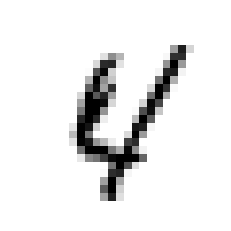

In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X.to_numpy()[700]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [5]:
y[700], type(y[700])

('4', str)

In this case X is casted as a DataFrame, we are going to transforme it to a pd
And y is a string rather than a integer

In [6]:
X = X.to_numpy()
y = y.astype(np.uint8)


Here in we can see the first 100 numbers of the data set

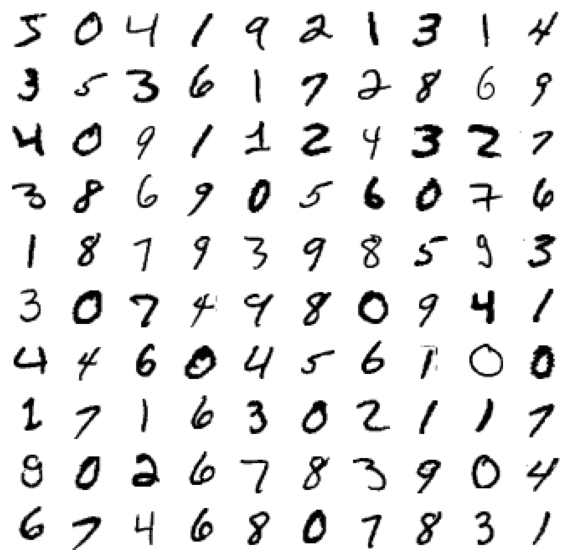

In [7]:
fig = plt.figure(figsize=(10, 10))
rows = 10
columns = 10
for i in range(rows*columns):
    fig.add_subplot(rows, columns, i+1)
    some_digit = X[i]
    some_digit_image = some_digit.reshape(28, 28)
    plt.imshow(some_digit_image, cmap="binary")
    plt.axis("off")


plt.show()

In [8]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Training a Binary Classifier

One digit classifier. Model capable of distinguishing between two instances, 5 and non-5.

In [9]:
y_train_5 = (y_train ==5)
y_test_5 = (y_test ==5)

In [10]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state = 42)
sgd_clf.fit(X_train, y_train_5)

sgd_clf.predict([some_digit])

array([False])

## Measuring accuracy using Cross-Validation
### Implementing Cross-Validation
In many cases the implementation of cross-validation have to bee done by ourown

In [11]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits = 3, random_state = 42, shuffle= True)

for train_index, test_index in skfolds.split(X_train, y_train_5):
    clone_clf = clone(sgd_clf)
    X_train_folds = X_train[train_index]
    X_test_folds = X_train[test_index]
    y_train_folds = y_train_5[train_index]
    y_test_folds = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_folds)
    n_correct = sum(y_pred == y_test_folds)
    print(n_correct / len(y_pred))

0.9669
0.91625
0.96785


In [12]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv = 3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

This classifier does perform above 93%. Let's check if any other classifier does equally well

In [13]:
from sklearn.base  import BaseEstimator

class Never5Classifier(BaseEstimator):
    def fit(self, X, y = None):
        return self
    def predict(self,X):
        return np.zeros((len(X), 1), dtype = bool)
        
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv = 3, scoring = 'accuracy')

array([0.91125, 0.90855, 0.90915])

A classifier that return always a 'NO 5' as output performs great 90 % of the time as the number 5 appears only 10 % in the original data set. Therefore in this case accuracy is nor a good metric for out problem of classifying 5 or not, as the dataset is skewed

## Confusion Matrix

The general idea is to count the number of instances of class A are classified as class B.

In [14]:
from sklearn.model_selection import cross_val_predict
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3)

In [15]:
from sklearn.metrics import confusion_matrix

confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

In [16]:
y_train_perfect_predictions = y_train_5
confusion_matrix(y_train_5, y_train_perfect_predictions)

array([[54579,     0],
       [    0,  5421]])

### **Precision**

$precision = \frac{TP}{TP+FP}$

### **Recall**

$recall = \frac{TP}{TP+FN}$

In [17]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [18]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

Ussually is convenient to combine precision and recalll in to a sigle metrica called $F_1 score$.

$F_1 score$ is the *harmonic mean* of precison and recall

$$F_1 = \frac{2}{\frac{1}{precision}+\frac{1}{recall}} = 2 x \frac{precison · recall}{precision + recall}$$

In [19]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

The SGDCLassifier makes it cassification decisiotns based on the score of a decision function. If the score is higher than the threshold it assigns the instance to the postive calls. Otherwise it assigns it to the negative class. 

The SGDClassifier does not allow to change the threshold directly, but it does give you access to the decision score that it uses to make predictions. Instead of calling the classifier's `predict()` method, you can call its `decision_function()` method, which returns a score for each instance, and then use any threshold you want to make predictions based on those scores

In [20]:
y_scores =sgd_clf.decision_function([some_digit])
y_scores

array([-4125.20277057])

In [21]:
threshold = 0
y_some_digit_predict = (y_scores >threshold)
y_some_digit_predict

array([False])

In [22]:
threshold =-5000
y_some_digit_predict = (y_scores >threshold)
y_some_digit_predict

array([ True])

In [23]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv = 3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

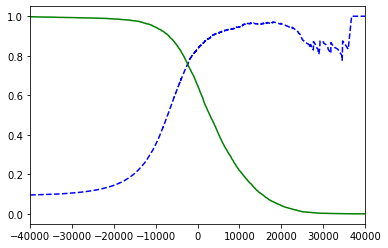

In [24]:
from sklearn.metrics import precision_recall_curve
precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

def plot_precision_recall_vs_threshold(precision, recalls, thresholds):
    plt.plot(thresholds, precision[:-1], 'b--', label = 'Precsion')
    plt.plot(thresholds, recalls[:-1], 'g-', label = 'Recall')
    plt.xlim(xmin = -40000, xmax = 40000)
plot_precision_recall_vs_threshold(precision, recalls, thresholds)

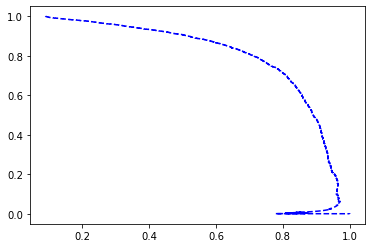

In [25]:
plt.plot(precision, recalls,'b--')

In [26]:
threshold_90_precision = thresholds[np.argmax(precision>=0.90)]
threshold_90_precision

3370.0194991439594

In [27]:
y_train_pred_90 =(y_scores>=threshold_90_precision)
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [28]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

## The ROC Curve

The *reciver operating characteristic* (ROC) curve is another commont tool used with binary classifiers. It is very similar to the precsion/recall curve, but instead of ploting precision versus recall, the ROC curve plots the true positive rate(another name for recall) against the *false positve rate* (FPR). The FPR is thr atio of negative insteance s thart are incorrectly calssified as positive. It is equal to 1- the *true negative* whic is the ratio of negative instances that are correctluy calssifeid as negative.

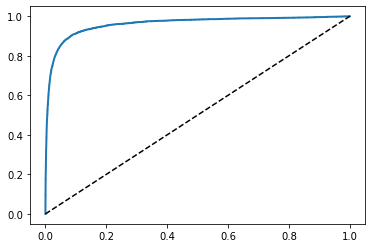

In [29]:
from sklearn.metrics import roc_curve

fpr, tpr, threshold = roc_curve(y_train_5, y_scores)

def plot_roc_curve( fpr, tpr, label= None):
    plt.plot(fpr, tpr, linewidth = 2, label =label)
    plt.plot([0,1],[0,1], 'k--') #Dashed diagonal
plot_roc_curve(fpr, tpr)

In [30]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_train_5, y_scores)

0.9604938554008616

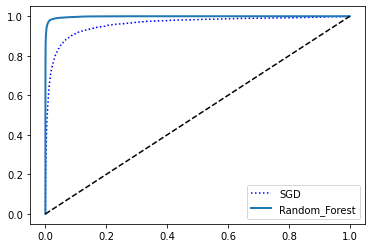

In [31]:
from sklearn.ensemble import RandomForestClassifier

fores_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(fores_clf, X_train, y_train_5, cv = 3, method='predict_proba')
y_scores_forest = y_probas_forest[:,1] #score = proba of positive classs
fpr_forest, tpr_forest, threshold_forest = roc_curve(y_train_5, y_scores_forest)

plt.plot(fpr, tpr, 'b:', label='SGD')
plot_roc_curve(fpr_forest, tpr_forest, 'Random_Forest')
plt.legend(loc = 'lower right')

In [32]:
roc_auc_score(y_train_5, y_scores_forest)

0.9983436731328145

In [33]:
y_probas_forest

array([[0.11, 0.89],
       [0.99, 0.01],
       [0.96, 0.04],
       ...,
       [0.02, 0.98],
       [0.92, 0.08],
       [0.94, 0.06]])

## One vs One / One vs all

In [34]:
from sklearn.svm import SVC

svm_clf = SVC()

svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([1], dtype=uint8)

In [35]:
some_digit_scores = svm_clf.decision_function([some_digit])

In [36]:
some_digit_scores

array([[-0.30727308,  9.31003099,  6.22374339,  3.09511851,  6.15897488,
         1.71471474,  0.69542629,  8.29964841,  4.12604772,  6.22776651]])

In [37]:
svm_clf.classes_[4]

4

In [38]:
sgd_clf.fit(X_train, y_train)
sgd_clf.decision_function([some_digit])

array([[-24463.25930983,   6295.60574118,  -4167.12075974,
          -926.29807662,  -3460.26911073,  -5590.89861073,
        -20394.704848  ,    614.85001197,  -1439.48933879,
         -4198.45757259]])

In [39]:
cross_val_score(sgd_clf, X_train, y_train, cv =3, scoring ='accuracy')

array([0.87365, 0.85835, 0.8689 ])

In [40]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))

In [41]:
cross_val_score(sgd_clf, X_train_scaled, y_train, cv = 3, scoring= 'accuracy')

array([0.8983, 0.891 , 0.9018])

## Error Analysis
Let's analyze the type of errors that we get out of our analysis
We are going to make predictionfs using the `cross_val_predict()`, then call the `confusion_matrix()`

In [42]:
y_traind_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv = 3)
conf_mx = confusion_matrix(y_train, y_traind_pred)
conf_mx

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

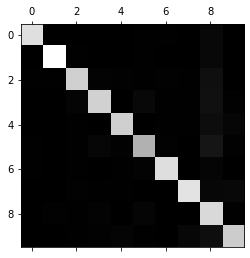

In [45]:
#Graphical representation of the confusion matrix
plt.matshow(conf_mx, cmap = plt.cm.gray)
plt.show()

We are going to divide each value in the confusion matrix by the number of images in the corrresponding calls so that you can compare error rates instead of absolute numbers of errors

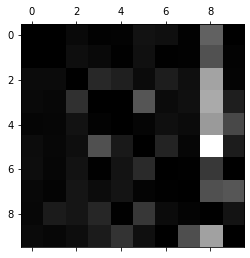

In [46]:
row_sums = conf_mx.sum(axis = 1, keepdims = True)
norm_conf_mx = conf_mx / row_sums #By diving the matrix by the sum of the columns we got a normalized matrix
np.fill_diagonal(norm_conf_mx, 0) #Setting the diagonal to 0 we will have more contrast
plt.matshow(norm_conf_mx, cmap = plt.cm.gray)

In [64]:
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

ZeroDivisionError: integer division or modulo by zero

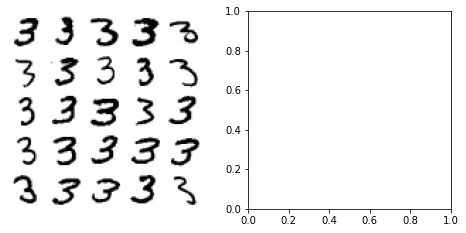

In [65]:
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train ==cl_a) & (y_train == cl_a)]
X_ab = X_train[(y_train ==cl_a) & (y_train == cl_b)]
X_ba = X_train[(y_train ==cl_b) & (y_train == cl_a)]
X_bb = X_train[(y_train ==cl_b) & (y_train == cl_b)]

plt.figure(figsize=(8,8))
plt.subplot(221); plot_digits(X_aa[:25], images_per_row = 5)
plt.subplot(222); plot_digits(X_ab[:25], images_per_row = 5)
plt.subplot(223); plot_digits(X_ba[:25], images_per_row = 5)
plt.subplot(224); plot_digits(X_bb[:25], images_per_row = 5)
plt.show()

## Multilabel Classification 

In [66]:
from sklearn.neighbors import KNeighborsClassifier
y_train_large = (y_train >= 7)
y_train_odd = (y_train%2 ==1)
y_train_multilabel = np.c_[y_train_large, y_train_odd]

knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train_multilabel)

KNeighborsClassifier()

In [67]:
knn_clf.predict([some_digit])

array([[False,  True]])

In [68]:
y_train_multilabel

array([[False,  True],
       [False, False],
       [False, False],
       ...,
       [False,  True],
       [False, False],
       [ True, False]])

In [69]:
y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train_multilabel, cv =3)
f1_score(y_train_multilabel, y_train_knn_pred, average = 'macro')

0.976410265560605

## Multiotput classification
I tis a simply generalization of mutilabel classification where each label can be mutliclass

Here we are going to introduce noise in the images from the MNIST to create a model that will denoise ti

In [70]:
noise = np.random.randint(0,100, (len(X_train), 28*28))
X_train_mod =X_train +noise

noise = np.random.randint(0,100, (len(X_test), 28*28))
X_test_mod =X_test +noise

y_train_mod = X_train
y_test_mod  = X_test

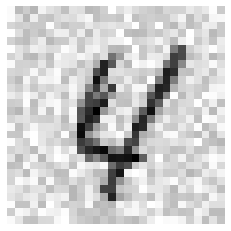

In [72]:
some_digit = X_train_mod[700]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

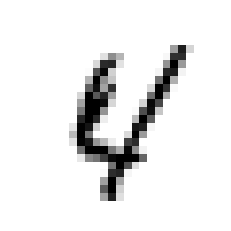

In [73]:
some_digit = X_train[700]
some_digit_image = some_digit.reshape(28, 28)
plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

In [77]:
knn_clf.fit(X_train_mod, X_train)
clean_digit = knn_clf.predict([X_test_mod[4]])


NameError: name 'plot_digit' is not defined

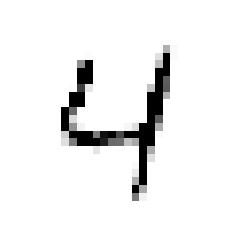

In [81]:
plt.imshow(clean_digit.reshape(28,28), cmap="binary")
plt.axis("off")
plt.show()